# qGAN for Stock Price Prediction

qGAN stands for Quantum Generative Adversarial Network, which is a hybrid quantum-classical algorithm used for generative modeling tasks. This algorithm differs from classical GAN in which it employs a quantum generator e.g. an ansatz (parameterized quantum circuit) and a classical discriminator such as a neural network to learn the relationship between features in the training data.

In [25]:
import time
import math
import torch 
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
from torch import nn, optim
from torch.backends import cudnn
from torch.utils.data import Dataset as TorchDataset, DataLoader
from qml.dataset import StockGANDataset
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from qiskit_aer import AerProvider
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import BackendEstimator
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_algorithms.utils import algorithm_globals
from qiskit_ibm_runtime import QiskitRuntimeService
from IPython.display import clear_output

## Initial Setup

### Setting up the hardware 

Qiskit allows the same circuit to be ran on different machines and environments by only swapping out the `backends`. Here we setup different providers and backends that will be used for training the model a.k.a. running the quantum circuit on. 

Note that `AerProvider` is from `qiskit_aer` which is a type of simulator that can be ran locally on our classical machines. Also, to better mimic the actual environment we acquire a NoiseModel from an actual quantum machine on the IBM Cloud but note that the noise model can only be applied while using the Aer backend.

In [26]:
aer_provider = AerProvider()
azure_provider = AzureQuantumProvider(
    Workspace(
        resource_id="/subscriptions/422cf85a-5643-4ef0-bafa-2809a5aa27e0/resourceGroups/qml/providers/Microsoft.Quantum/Workspaces/stockqgan", 
        location="eastus"
    )
)
# ibm_service = QiskitRuntimeService(channel="ibm_quantum", token="ac6000c560e92b674e0ebbaa683a55dceabb7aa1017e57b5c2f2ce865bebb29e719a8b90180a5d335b0e0fa0698e43ba35c0b76e89bd5dab1fba6cd657c65f71")

# Create Aer simulator backend
aer_backend = aer_provider.get_backend("qasm_simulator")

# Create Rigetti simulator and QPU backends
rigetti_simulator_backend = azure_provider.get_backend("rigetti.sim.qvm")
rigetti_qpu_backend = azure_provider.get_backend("rigetti.qpu.ankaa-2")

# Create an IBM backend
# ibm_backend = ibm_service.least_busy(operational=True, simulator=False)

# Get the noise model from an actual quantum machine
# noise_model = NoiseModel.from_backend(ibm_backend)

backend = rigetti_simulator_backend

Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


### Specifying a random seed

This step is important so that the initial weights on each run is similar which helps in reproduction that comes in handy during the initial development and debugging.

In [27]:
algorithm_globals.random_seed = 1337
_ = torch.manual_seed(1337)

In [28]:
DATASET_DIR = "../../datasets" # Directory where datasets will be downloaded to
OUTPUT_DIR = "qvm_sim_pca_4"   # Results will be saved to this directory

TICKERS = [
    "AAPL", # Apple
    "AMD",  # Advanced Micro Devices
    "AMZN", # Amazon
    "COST", # Costco
    "GOOG", # Google
    "INTC", # Intel
    "META", # Meta (Facebook)
    "NFLX", # Netflix
    "NVDA", # Nvidia
    "TSM",  # TSMC
    "YM=F", # Dow Jones Index
    "^NDX", # Nasdaq Index
    "^SPX", # Standard & Poor 500 Index
    "TSLA", # Tesla
]
TARGET = "AAPL"

## Data Preprocessing

### Downloading historical stock prices from Yahoo Finance

Here we are using existing code from the classical counterparts hence some parameters is not important since we will be pre-processing the data ourselves later.

In [29]:
# Download the stock prices, note that some parameters here does not matter since we will be pre-processing our data with a custom class later
dataset = StockGANDataset(
    tickers=TICKERS,
    target_ticker=TARGET,
    start=datetime(year=2023, month=1, day=1, tzinfo=timezone.utc),
    end=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
    interval="1d",
    sliding_window=1,          # does not matter 
    train_test_pct=(0.8, 0.2), # does not matter
    root=DATASET_DIR
)

The dataframe as shown below is the daily close price for the tickers specified above.

In [30]:
dataset.data

timestamp,AAPL,AMD,AMZN,COST,GOOG,INTC,META,NFLX,NVDA,TSM,YM=F,^NDX,^SPX,TSLA
"datetime[ns, America/New_York]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-01-03 00:00:00 EST,124.216301,64.019997,85.82,439.224854,89.699997,26.044008,124.607788,294.950012,143.079773,72.324837,33278.0,10862.639648,3824.139893,108.099998
2023-01-04 00:00:00 EST,125.497498,64.660004,85.139999,442.403046,88.709999,26.969627,127.235008,309.410004,147.417679,74.562096,33416.0,10914.799805,3852.969971,113.639999
2023-01-05 00:00:00 EST,124.166634,62.330002,83.120003,436.230591,86.769997,26.852705,126.805458,309.700012,142.580048,73.98568,33070.0,10741.219727,3808.100098,110.339996
2023-01-06 00:00:00 EST,128.735229,63.959999,86.080002,467.897278,88.160004,27.99268,129.882202,315.549988,148.51712,76.271782,33772.0,11040.349609,3895.080078,113.059998
2023-01-09 00:00:00 EST,129.261627,67.239998,87.360001,463.90506,88.800003,28.557793,129.332779,315.170013,156.203369,78.460197,33670.0,11108.450195,3892.090088,119.769997
2023-01-10 00:00:00 EST,129.837677,68.050003,89.870003,466.472839,89.239998,28.684462,132.849045,327.540009,159.011963,79.398079,33849.0,11205.780273,3919.25,118.849998
2023-01-11 00:00:00 EST,132.578842,69.059998,95.089996,469.292603,92.260002,29.083937,132.749146,327.26001,159.931534,79.896332,34110.0,11402.519531,3969.610107,123.220001
2023-01-12 00:00:00 EST,132.49939,70.800003,95.269997,467.470886,91.910004,29.512648,136.565109,330.130005,165.029037,84.996086,34319.0,11459.610352,3983.169922,123.559998
2023-01-13 00:00:00 EST,133.840164,71.0,98.120003,470.203461,92.800003,29.337265,136.834808,332.820007,168.907135,84.800713,34416.0,11541.480469,3999.090088,122.400002


### Preprocessing the data

The `Dataset` class below is similar to `StockGANDataset` but adapted for the qGAN. Here we do a 80/20 train test split and note that we do not shuffle the data since these are timeseries data and their order has to be mantained otherwise the dataset loses its meaning.

Since we represent a feature with a qubit hence it is important to keep the number of features down as increasing number of qubits will significantly increase the training time. Therefore, we perform dimension reduction on the dataset by applying principal component analysis (PCA) to acquire 4 principal components which corresponds to 4 qubits later.

Lastly, since the stock prices are vastly different across different tickers, we perform min-max scaling to normalise them to the range of (0, 1).

In [31]:
class Dataset(TorchDataset):
    def __init__(self, data: pl.DataFrame):
        self.in_scaler = MinMaxScaler(feature_range=(0, 1))
        self.out_scaler = MinMaxScaler(feature_range=(0, 1))

        train_data, test_data = train_test_split(
            data.drop("timestamp").to_numpy(), 
            train_size=0.8, 
            shuffle=False, # must not shuffle timeseries data
        )
        self.train_x, self.train_y = (
            torch.from_numpy(self.in_scaler.fit_transform(PCA(n_components=4).fit_transform(train_data))).float(), 
            torch.from_numpy(self.out_scaler.fit_transform(train_data.T[0].reshape(-1, 1))).float(),
        )
        self.test_x, self.test_y = (
            torch.from_numpy(self.in_scaler.fit_transform(PCA(n_components=4).fit_transform(test_data))).float(),
            torch.from_numpy(self.out_scaler.fit_transform(test_data.T[0].reshape(-1, 1))).float(),
        )

    def __len__(self):
        return self.train_x.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.train_x[index], self.train_y[index]

dataset = Dataset(data=dataset.data)

In [32]:
num_features = dataset.train_x.shape[1]

## Neural Network Definition

As described above, there are two major components in a qGAN:

- Quantum Generator
- Classical Discriminator

This section goes through the definition for each of the network.

### Quantum Generator

#### Feature Map

Since our dataset are classical meaning that they are represented in classical bits, we need a feature map (parameterized quantum circuit) to transform classical data into a quantum state that can be processed by a quantum computer or simulator.

In this case we chose `ZZFeatureMap` (second-order Pauli-Z evolution) from Qiskit mainly due to its expressiveness since it was constructed with a series of controlled rotations which can effectively encode information about pairwise interactions between features of the input data. This allows it to capture non-linearities between the input data which is important because the relationship between each stock price is usually non-linear.

Note that in the circuit digram above there are four `x` from `x[0]` to `x[3]` which represents the 4 principal components in the dataset. Also, we kept the repetitions to **1** to lessen the training time, if we want to increase the expressivity of the feature map later we can increase the number of repetitions but at a cost of more compute.

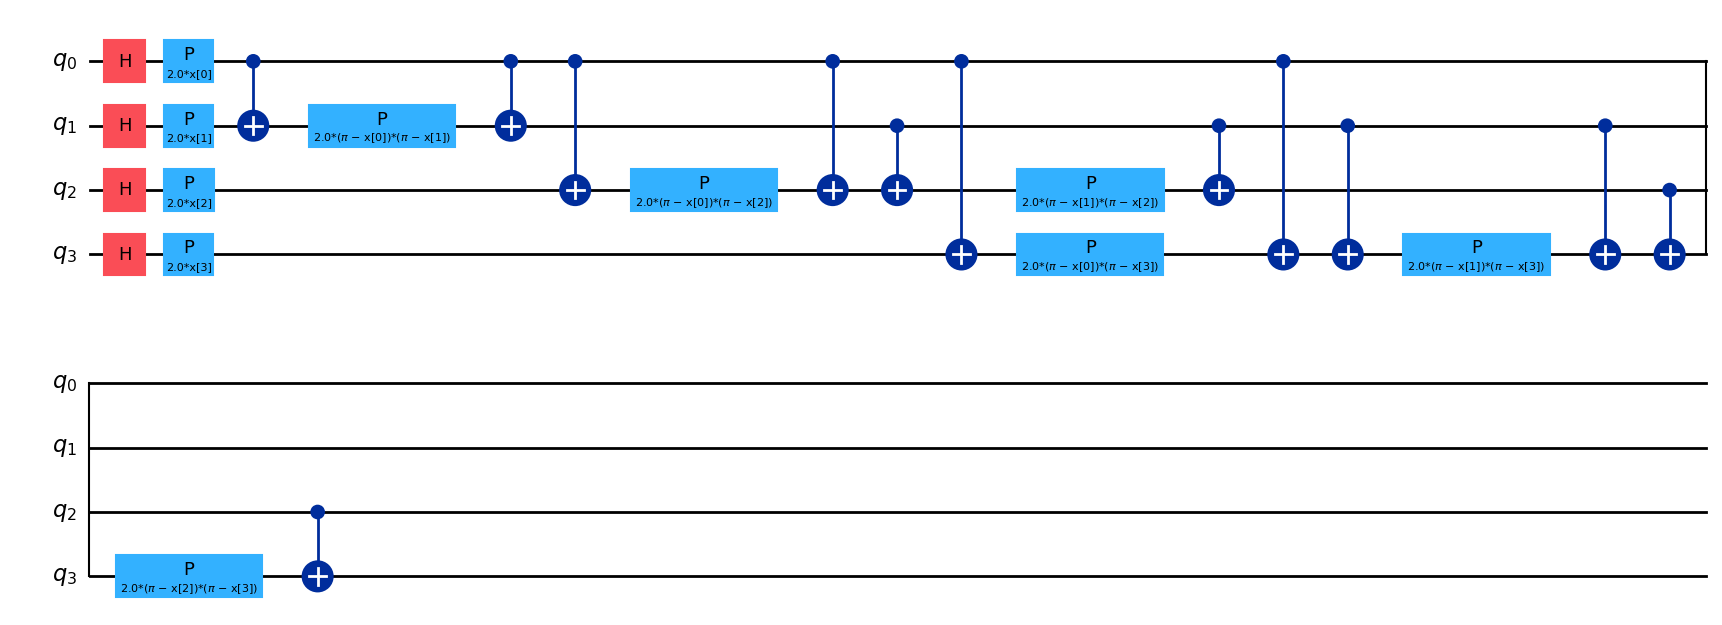

In [33]:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw('mpl')

#### Ansatz

The most important part of the quantum generator lies in its ansatz which is a parameterized quantum circuit that serves as a starting point for the neural network where the training process would find the parameters of this circuit that minimise the loss function. 

For example, in the ansatz below we can see that each rotation gate, $R_y$ and $R_z$ has a $\theta$ parameter attached to them and these are equivalent to "weights" in a classical neural network. Since there are 16 rotation gates hence there are 16 weight parameters that can be optimised.

In this case, we chose `EfficientSU2` due to its compactness and expressiveness. However, if we want to later configure the expressivity of the ansatz we can swap it out for `RealAmplitude` since it provides the flexibility to configure entangling gates. By default `EfficientSU2` uses CNOT gates as its entangling gates. Note that we also kept the repetition to **1** to keep the training time down.

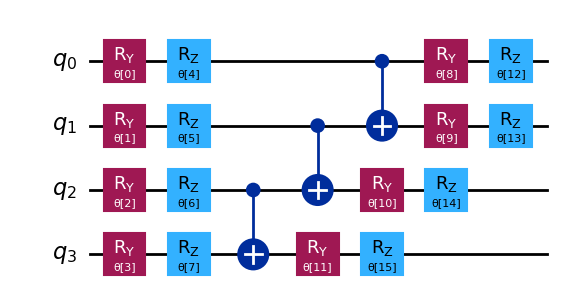

In [34]:
ansatz = EfficientSU2(num_qubits=num_features, reps=1)
ansatz.decompose().draw('mpl')

Now we use `QNNCircuit` to compose both the feature map and the ansatz in to one single quantum circuit.

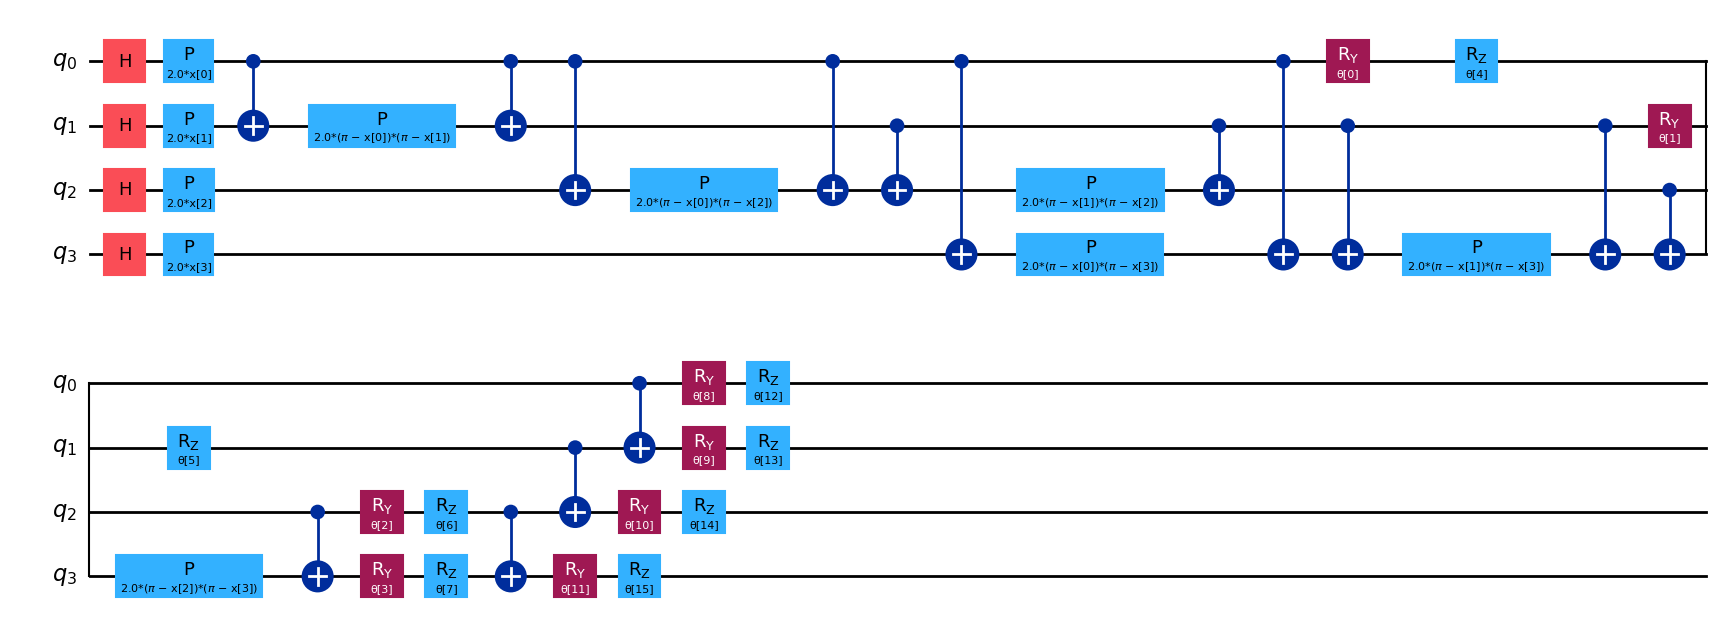

In [35]:
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
qc.decompose().draw('mpl')

The `shots` here determine the number of shots each time a job is triggered.

In [36]:
shots = 1000
estimator = BackendEstimator(
    backend=backend,
    options={
        "shots": shots, 
        "seed": algorithm_globals.random_seed,
        # "noise_model": noise_model,
    } if backend == aer_backend else {"shots": shots}
)

def create_generator() -> nn.Module:
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        input_params=qc.input_parameters,
        weight_params=qc.weight_parameters,
    )
    initial_weights = algorithm_globals.random.random(qc.num_weight_parameters)
    return TorchConnector(qnn, initial_weights)

### Classical Discriminator



In [37]:
class Discriminator(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3: torch.Tensor = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

## Training

In [38]:
def plot_training_progress(generator_loss_values, discriminator_loss_values):
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend()
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()
    
    plt.show()

### Setup the classical training device

Use CUDA (Nvidia GPU) if available otherwise CPU.

In [39]:
CUDA = torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.2.0+cu121


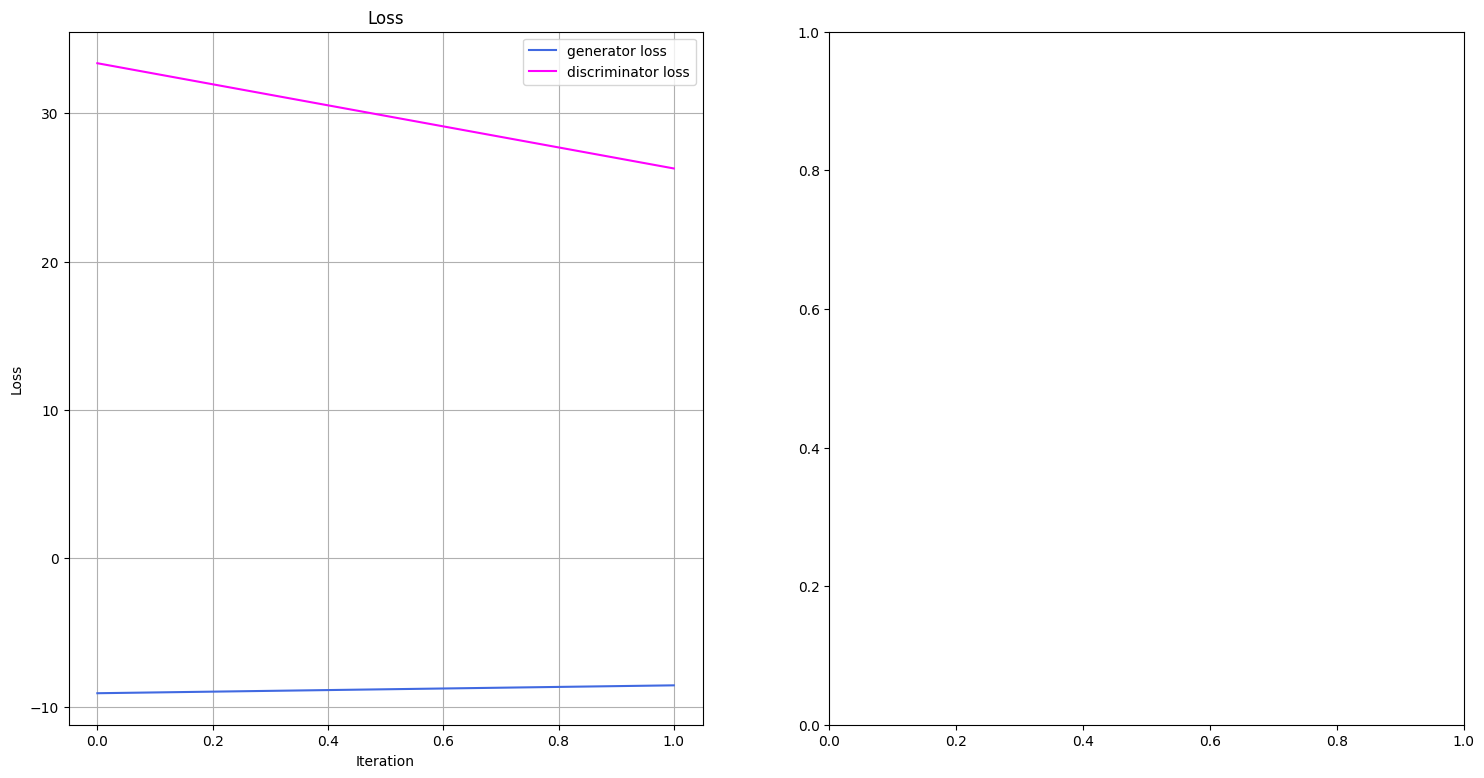

Epoch 2 took 28243.43 seconds: g_loss=-8.56 d_loss=26.28
in epoch 2
in batch 0
2024-04-26 11:43:33.693282: discriminating true labels
2024-04-26 11:43:33.693498: generating fake data
.................................................................................................................................................................................................................................................................................................................................................................2024-04-26 11:52:46.488875: backpropagating generator


Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [41]:
EPOCHS = 10
LEARNING_RATE = 0.01
BETAS = (0.0, 0.9)
BATCH_SIZE = 125

generator, discriminator = create_generator(), Discriminator(1)

loss = nn.BCELoss()
g_optim, d_optim = (
    optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=BETAS),
    optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=BETAS)
)

dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

g_losses, d_losses = [], []

start = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    g_local_losses, d_local_losses = [], []

    print(f"in epoch {epoch}")

    # Get next batch of data from the dataloder
    for i, (x, y) in enumerate(dataloader):
        print(f"in batch {i}")
        x = x.to(device)
        y = y.to(device)

        # Generate fake data
        print(f"{datetime.now()}: generating fake data")
        fake_data = generator(x)

        # Train the discriminator to understand true labels
        print(f"{datetime.now()}: discriminating true labels")
        d_real_output = discriminator(y.unsqueeze(1))
        real_labels = torch.ones_like(d_real_output).to(device)
        d_loss_real = loss(d_real_output, real_labels)

        # Train the discriminator to understand false label
        print(f"{datetime.now()}: discriminating false labels")
        d_fake_output = discriminator(fake_data.unsqueeze(1))
        fake_labels = torch.zeros_like(real_labels).to(device)
        d_loss_fake = loss(d_fake_output, fake_labels)

        # Optimise the discriminator loss
        d_loss = (d_loss_real + d_loss_fake)
        discriminator.zero_grad()
        print(f"{datetime.now()}: backpropagating discriminator")
        d_loss.backward(retain_graph=True)
        d_optim.step()
        d_local_losses.append(d_loss.item())

        # Optimise the generator loss
        print(f"{datetime.now()}: discriminating false labels")
        d_fake_output = discriminator(fake_data.unsqueeze(1))
        g_loss = loss(d_fake_output, real_labels)
        generator.zero_grad()
        print(f"{datetime.now()}: backpropagating generator")
        g_loss.backward()
        g_optim.step()
        g_local_losses.append(g_loss.item()) 

    g_losses.append(sum(g_local_losses))
    d_losses.append(sum(d_local_losses))

    plot_training_progress(g_losses, d_losses)
    epoch_elapsed = time.time() - epoch_start
    print(f"Epoch {epoch + 1} took {epoch_elapsed:.2f} seconds: g_loss={sum(g_local_losses):.2f} d_loss={sum(d_local_losses):.2f}")

elapsed = time.time() - start
print(f"Trained in {elapsed:0.2f} seconds")

torch.save(generator.state_dict(), f"{OUTPUT_DIR}/stock_qgan_generator")
torch.save(discriminator.state_dict(), f"{OUTPUT_DIR}/stock_qgan_discriminator")

## Model Evaluation

### Evaluate the training loss

In contrast with other machine learning approaches, the ideal scenario for GAN is not steadily converging to a certain value. In fact, the discriminator and generator should maintain a dynamic balance since they are competing against each other. Therefore, it is common to see flunctuations in the training loss as an indication of the ongoing tug-of-war between the discriminator and generator.

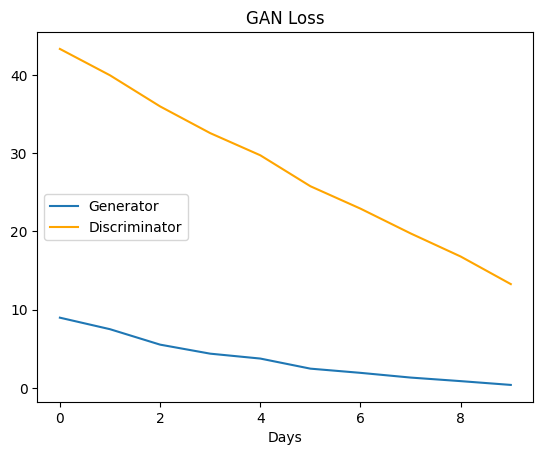

In [ ]:
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator', color='orange')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc='center left')

### Evaluate the model on train and test data

Since this is not a classification problem, it does not make sense to measure the accuracy, F1-Score, etc. However, this problem is suitable to use regression metrics and I chose the following to evaluate the model performance.

- Root Mean Square Error (closer to $0.0$ is better)
- $R^2$ (coefficient of determination, closer to $1.0$ is better, can be negative)

In [ ]:
generator.eval()
pred_y_train: torch.Tensor = generator(dataset.train_x)
pred_y_test: torch.Tensor = generator(dataset.test_x)

y_train_true = dataset.out_scaler.inverse_transform(dataset.train_y.reshape(-1, 1))
y_train_pred = dataset.out_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = dataset.out_scaler.inverse_transform(dataset.test_y.reshape(-1, 1))
y_test_pred = dataset.out_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset
RMSE: 21.356638498405324
R2: -7.0200482105929165


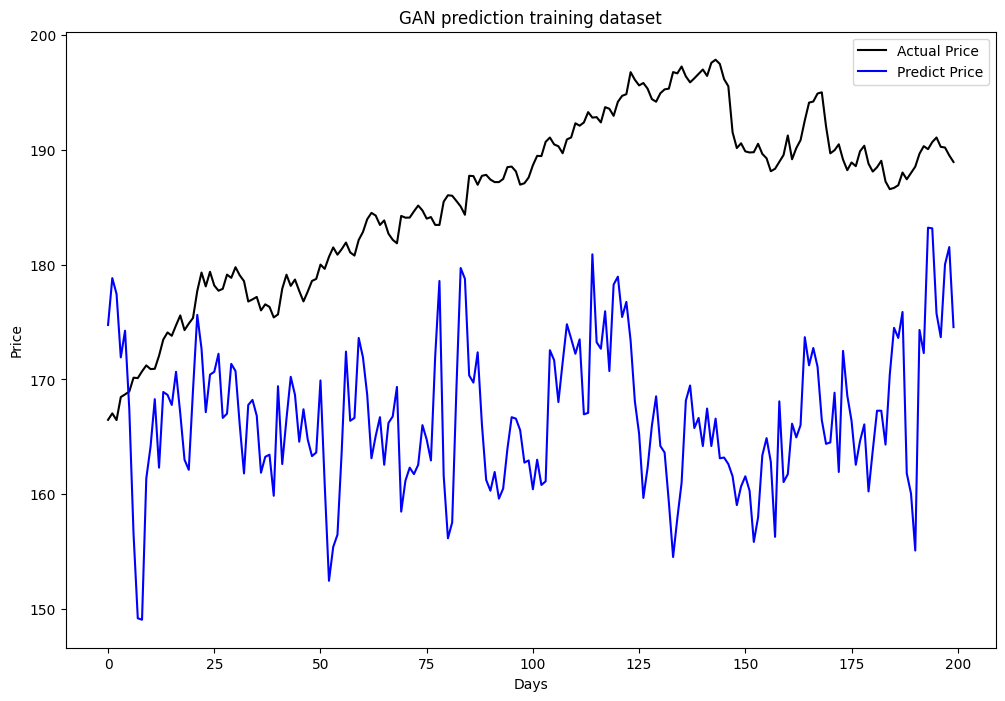

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_train_true, y_train_pred)
print(f'Training dataset\nRMSE: {RMSE}\nR2: {R2}')

Test dataset
RMSE: 24.670950627833218
R2: -6.412351839425159


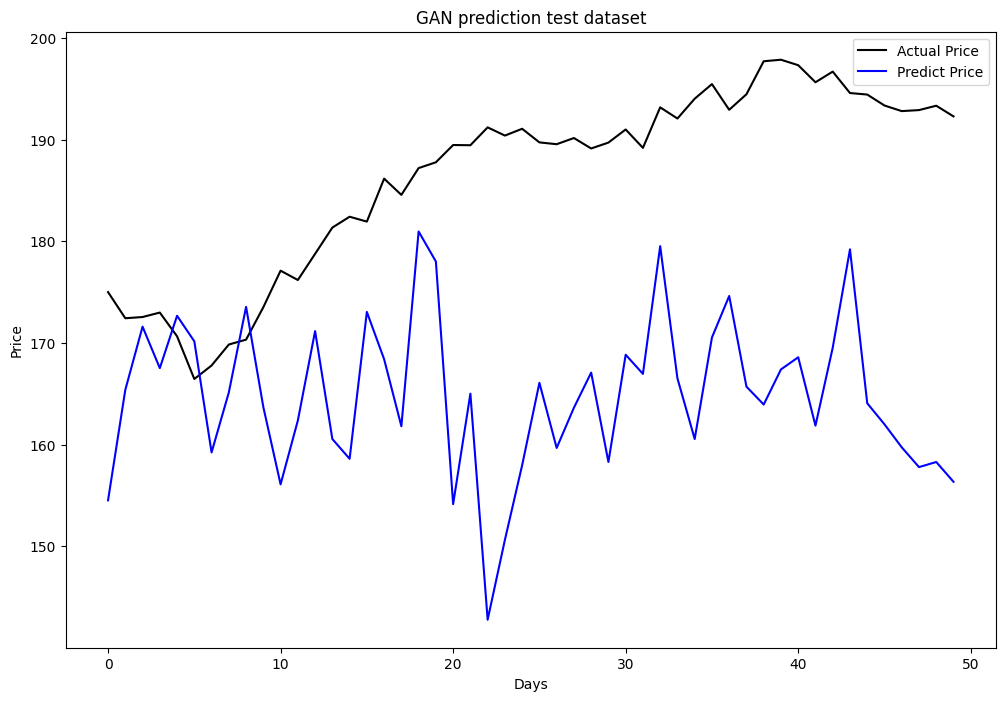

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction test dataset')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test_true, y_test_pred)
print(f'Test dataset\nRMSE: {RMSE}\nR2: {R2}')

Export the results to the output directory

In [ ]:
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_g_losses.txt", g_losses, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_d_losses.txt", d_losses, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_train_true.txt", y_train_true, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_train_pred.txt", y_train_pred, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_test_true.txt", y_test_true, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_test_pred.txt", y_test_pred, delimiter=',')